### Experiment: Normalization

**Question**: Is normalization necessary? If so, what kind performs best?

**Hypothesis**: The data is already re-referenced using `mne.set_eeg_reference("average")` during pre-processing. The range used is approximately $[-55, 55]$, models might work better at a more commonly used range of $[0,1]$, or $[-1, 1]$ to keep negative numbers.

**Result**:

#### Part 1: Investigation

In [1]:
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
from pathlib import Path

In [4]:
data_path = Path("data/sat1/split_stage_data.nc")
data = xr.load_dataset(data_path)

##### Histogram of distribution of all values

<xarray.DataArray 'histogram_data' (data_bin: 59)>
array([      3,       3,       3,       5,       7,      12,      25,
            24,      30,      48,      89,      89,     147,     237,
           394,     679,    1187,    2081,    3663,    6684,   12336,
         22788,   41775,   76825,  139558,  249879,  433019,  710368,
       1070105, 1402103, 1528583, 1356048, 1001801,  650524,  390008,
        224940,  128136,   72061,   41663,   24037,   14097,    8442,
          4860,    3068,    1755,    1138,     690,     419,     222,
           154,     101,      56,      28,      28,      16,      11,
             6,       0,       2])
Coordinates:
  * data_bin  (data_bin) float64 -57.9 -55.97 -54.03 -52.1 ... 50.44 52.37 54.31

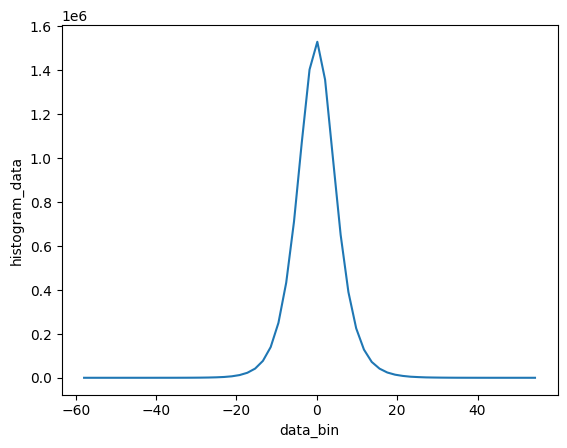

In [3]:
max = data.max().data.item()
min = data.min().data.item()
bins = np.linspace(min, max, 60)
hist = histogram(data.data, bins=bins, block_size=data.samples.size)
display(hist)
hist.plot()

##### Histogram of distribution for each channel

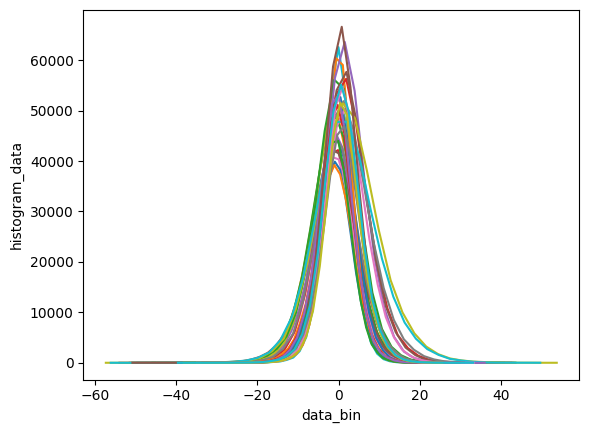

In [4]:
for channel in data.channels:
    data_subset = data.sel(channels=channel)
    max = data_subset.max().data.item()
    min = data_subset.min().data.item()
    bins = np.linspace(min, max, 40)
    hist = histogram(data_subset.data, bins=bins, block_size=data_subset.samples.size)
    hist.plot()

#### Part 2: Experiment

In [1]:
from shared.training import k_fold_cross_validate
from shared.normalization import *
from shared.models import SAT1Base
from shared.utilities import print_results
import tensorflow as tf
import gc
from pathlib import Path
import xarray as xr
%env TF_FORCE_GPU_ALLOW_GROWTH=true
%env TF_GPU_ALLOCATOR=cuda_malloc_async

2023-10-13 12:28:25.823623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 12:28:26.516348: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


env: TF_FORCE_GPU_ALLOW_GROWTH=true
env: TF_GPU_ALLOCATOR=cuda_malloc_async


In [2]:
data_path = Path("data/sat1/split_stage_data.nc")

data = xr.load_dataset(data_path)

In [3]:
norm_fns = [norm_dummy, norm_0_to_1, norm_min1_to_1]


def test_normalization(norm_fn):
    tf.keras.backend.clear_session()
    print(f"Testing norm_fn: {norm_fn.__name__}")
    model = SAT1Base(len(data.channels), len(data.samples), len(data.labels))
    model.compile(
        optimizer=tf.keras.optimizers.Nadam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    train_kwargs = {
        "logs_path": Path("logs/exp_normalization/"),
        "additional_info": {"norm_fn": norm_fn.__name__},
        "additional_name": f"norm_fn-{norm_fn.__name__}",
    }
    result = k_fold_cross_validate(
        data, model, k=5, normalization_fn=norm_fn, train_kwargs=train_kwargs
    )
    print_results(result)
    del model
    gc.collect()

In [4]:
test_normalization(norm_fns[0])

Testing norm_fn: norm_dummy


2023-10-13 12:16:19.080247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-13 12:16:19.115215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-13 12:16:19.115329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-13 12:16:19.118995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-13 12:16:19.119210: I tensorflow/compile

Fold 1: test fold: ['0009' '0017' '0001' '0024' '0012']
Epoch 1/10


2023-10-13 12:16:22.116654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-13 12:16:22.823029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-13 12:16:23.143634: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f995a264320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-13 12:16:23.143668: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-13 12:16:23.149704: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-13 12:16:23.260131: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

999/999 [==============================] - 11s 7ms/step - loss: 0.7667 - accuracy: 0.7233
Epoch 2/10
999/999 [==============================] - 7s 7ms/step - loss: 0.5522 - accuracy: 0.8020
Epoch 3/10
999/999 [==============================] - 7s 7ms/step - loss: 0.4922 - accuracy: 0.8249
Epoch 4/10
999/999 [==============================] - 7s 7ms/step - loss: 0.4564 - accuracy: 0.8355
Epoch 5/10
999/999 [==============================] - 7s 7ms/step - loss: 0.4142 - accuracy: 0.8515
Epoch 6/10
999/999 [==============================] - 7s 7ms/step - loss: 0.3808 - accuracy: 0.8627
Epoch 7/10
999/999 [==============================] - 7s 7ms/step - loss: 0.3445 - accuracy: 0.8757
Epoch 8/10
999/999 [==============================] - 7s 7ms/step - loss: 0.3197 - accuracy: 0.8841
Epoch 9/10
999/999 [==============================] - 7s 7ms/step - loss: 0.2979 - accuracy: 0.8906
Epoch 10/10
254/254 [==============================] - 3s 10ms/step
Fold 1: accuracy: 0.8220964566929134
Fold 

In [4]:
test_normalization(norm_fns[1])

Testing norm_fn: norm_0_to_1


2023-10-13 12:28:37.597829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-13 12:28:37.638046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-13 12:28:37.638242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-13 12:28:37.643447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-13 12:28:37.643568: I tensorflow/compile

Fold 1: test fold: ['0009' '0017' '0001' '0024' '0012']
Epoch 1/10


2023-10-13 12:28:41.408676: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-13 12:28:42.153482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-13 12:28:42.492786: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff3374ca330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-13 12:28:42.492829: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-13 12:28:42.499352: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-13 12:28:42.612158: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

999/999 [==============================] - 11s 7ms/step - loss: 1.1405 - accuracy: 0.5206
Epoch 2/10
999/999 [==============================] - 8s 8ms/step - loss: 0.8527 - accuracy: 0.6709
Epoch 3/10
999/999 [==============================] - 8s 8ms/step - loss: 0.6309 - accuracy: 0.7656
Epoch 4/10
999/999 [==============================] - 8s 8ms/step - loss: 0.5675 - accuracy: 0.7881
Epoch 5/10
999/999 [==============================] - 8s 8ms/step - loss: 0.5185 - accuracy: 0.8117
Epoch 6/10
999/999 [==============================] - 8s 8ms/step - loss: 0.4856 - accuracy: 0.8233
Epoch 7/10
999/999 [==============================] - 8s 8ms/step - loss: 0.4656 - accuracy: 0.8310
Epoch 8/10
999/999 [==============================] - 8s 8ms/step - loss: 0.4455 - accuracy: 0.8341
Epoch 9/10
999/999 [==============================] - 7s 7ms/step - loss: 0.4282 - accuracy: 0.8435
Epoch 10/10
254/254 [==============================] - 3s 10ms/step
Fold 1: accuracy: 0.8156988188976378
Fold 

In [5]:
test_normalization(norm_fns[2])

Testing norm_fn: norm_min1_to_1
Fold 1: test fold: ['0009' '0017' '0001' '0024' '0012']
Epoch 1/10
999/999 [==============================] - 9s 7ms/step - loss: 0.7606 - accuracy: 0.7181
Epoch 2/10
999/999 [==============================] - 8s 7ms/step - loss: 0.5872 - accuracy: 0.7899
Epoch 3/10
999/999 [==============================] - 8s 7ms/step - loss: 0.5167 - accuracy: 0.8158
Epoch 4/10
999/999 [==============================] - 8s 7ms/step - loss: 0.4732 - accuracy: 0.8278
Epoch 5/10
999/999 [==============================] - 7s 7ms/step - loss: 0.4430 - accuracy: 0.8418
Epoch 6/10
999/999 [==============================] - 7s 7ms/step - loss: 0.4127 - accuracy: 0.8494
Epoch 7/10
999/999 [==============================] - 8s 7ms/step - loss: 0.3915 - accuracy: 0.8573
Epoch 8/10
999/999 [==============================] - 7s 7ms/step - loss: 0.3679 - accuracy: 0.8661
Epoch 9/10
999/999 [==============================] - 8s 8ms/step - loss: 0.3431 - accuracy: 0.8732
Epoch 10/10


In [6]:
# View results in Tensorboard
! tensorboard --logdir logs/exp_normalization/

2023-10-13 12:51:56.620059: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
